# Logistic Regression

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as onp

In [2]:
df = sm.datasets.get_rdataset('urine', package='boot').data

/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/statsmodels/datasets/utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


In [3]:
df.head()

,r,gravity,ph,osmo,cond,urea,calc
0,0,1.021,4.91,725.0,NaN,443,2.45
1,0,1.017,5.74,577.0,20.0,296,4.49
2,0,1.008,7.20,321.0,14.9,101,2.36
3,0,1.011,5.51,408.0,12.6,224,2.15
4,0,1.005,6.52,187.0,7.5,91,1.16


In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,r,gravity,ph,osmo,cond,urea,calc
0,0,1.017,5.74,577.0,20.0,296,4.49
1,0,1.008,7.20,321.0,14.9,101,2.36
2,0,1.011,5.51,408.0,12.6,224,2.15
3,0,1.005,6.52,187.0,7.5,91,1.16
4,0,1.020,5.27,668.0,25.3,252,3.34


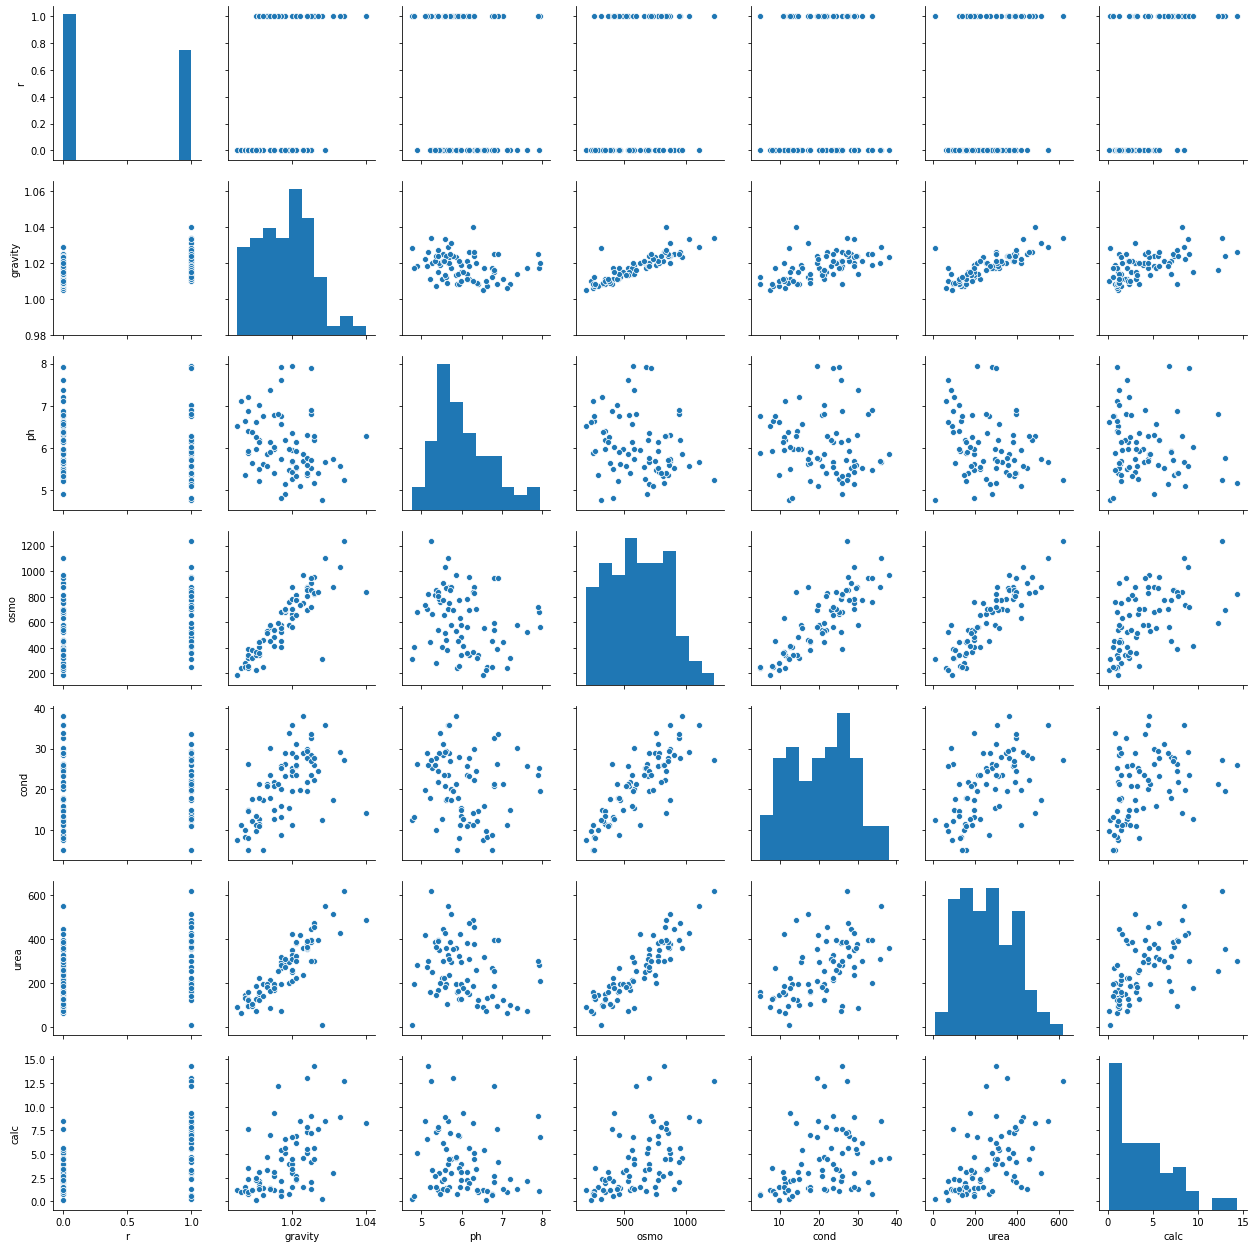

In [5]:
sns.pairplot(df)

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df.r = df.r

In [7]:
scaled_df.head()

,r,gravity,ph,osmo,cond,urea,calc
0,0,-0.141224,-0.419103,-0.153881,-0.113832,0.259167,0.100631
1,0,-1.380060,1.616126,-1.229902,-0.755181,-1.245042,-0.549665
2,0,-0.967114,-0.739721,-0.864223,-1.044416,-0.296233,-0.613779
3,0,-1.793005,0.668211,-1.793131,-1.685765,-1.322181,-0.916030
4,0,0.271722,-1.074279,0.228611,0.552667,-0.080244,-0.250468


In [8]:
df.head()

,r,gravity,ph,osmo,cond,urea,calc
0,0,1.017,5.74,577.0,20.0,296,4.49
1,0,1.008,7.20,321.0,14.9,101,2.36
2,0,1.011,5.51,408.0,12.6,224,2.15
3,0,1.005,6.52,187.0,7.5,91,1.16
4,0,1.020,5.27,668.0,25.3,252,3.34


In [9]:
scaled_df.apply(np.std)

r          0.494872
gravity    1.000000
ph         1.000000
osmo       1.000000
cond       1.000000
urea       1.000000
calc       1.000000
dtype: float64

In [10]:
dat = scaled_df.values
C = dat[..., 0]
X = dat[..., 1:]

## Define the model

In [11]:
from jax import random, lax, nn
import jax.numpy as np  # We need the CUDA mirror of numpy (even if we're on a CPU)

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)  # Run mcmc in parallel
numpyro.enable_validation()  # Let pyro alert me to potential problems

num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [12]:
# Numpyro doesn't have a Laplace distribution?? I guess we have to make our own

class Laplace(dist.Distribution):
    arg_constraints = {'loc': dist.constraints.real, 'scale': dist.constraints.positive}
    support = dist.constraints.real
    reparametrized_params = ['loc', 'scale']

    def __init__(self, loc=0., scale=1., validate_args=None):
        self.loc, self.scale = dist.util.promote_shapes(loc, scale)
        batch_shape = lax.broadcast_shapes(np.shape(loc), np.shape(scale))
        super().__init__(batch_shape=batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        eps = random.laplace(key, shape=sample_shape + self.batch_shape + self.event_shape)
        return self.loc + eps * self.scale

    @dist.util.validate_sample
    def log_prob(self, value):
        normalize_term = np.log(1/(2*self.scale))
        value_scaled = np.abs(value - self.loc) / self.scale
        return -1*value_scaled + normalize_term

    def icdf(self, q):
        return self.loc + self.scale * ndtri(q)

    @property
    def mean(self):
        return np.broadcast_to(self.loc, self.batch_shape)

    @property
    def variance(self):
        return np.broadcast_to(2 * self.scale ** 2, self.batch_shape)

In [13]:
def model_fn(X, C):
    w = numpyro.sample('w', Laplace(np.zeros(6), np.sqrt(2)))
    int_ = numpyro.sample('int_', dist.Normal(0, 25))
    
    z = X @ w + int_
    
    l = nn.sigmoid(z)
    
    numpyro.sample('c', dist.Bernoulli(l), obs=C)

In [14]:
kernel = NUTS(model_fn)
model = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model.run(rng_key, collect_warmup=False, X=X, C=C)

In [15]:
model.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      int_     -0.08      0.34     -0.08     -0.64      0.46   9127.50      1.00
      w[0]      2.55      1.04      2.48      0.78      4.16   7945.52      1.00
      w[1]     -0.20      0.34     -0.19     -0.77      0.35   9654.43      1.00
      w[2]     -0.30      1.40     -0.22     -2.56      1.97   6493.87      1.00
      w[3]     -1.12      0.75     -1.09     -2.27      0.12   6522.03      1.00
      w[4]     -1.28      0.91     -1.22     -2.72      0.16   6197.94      1.00
      w[5]      1.97      0.57      1.93      1.06      2.93   8535.08      1.00

Number of divergences: 0


In [16]:
samples = model.get_samples()

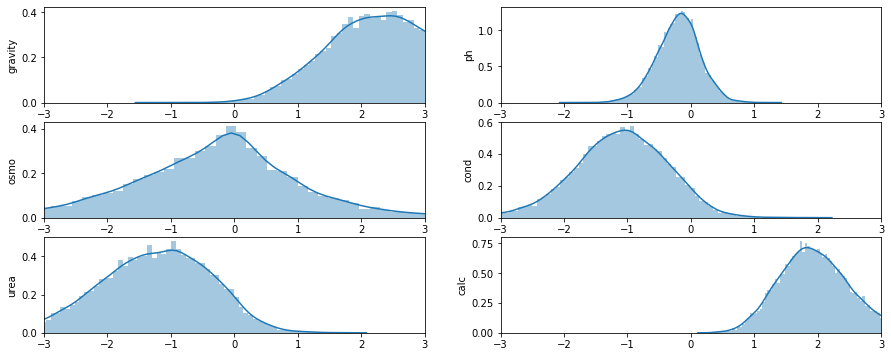

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(15,6))
[sns.distplot(samples['w'][:, i], bins=100, ax=ax) for i, ax in enumerate(axs.ravel())]
[ax.set_ylabel(scaled_df.columns[i+1]) for i, ax in enumerate(axs.ravel())]
[ax.set_xlim(-3, 3) for ax in axs.ravel()];

## Simpler model

In [18]:
def model1_fn(X, C):
    w = numpyro.sample('w', dist.Normal(np.zeros(3), 25))
    int_ = numpyro.sample('int_', dist.Normal(0, 25))
    
    z = X @ w + int_
    
    numpyro.sample('c', dist.BernoulliLogits(z), obs=C)

In [19]:
# we only want to keep gravity, cond, and calc
# Lets see what indecies they are
print(list(zip(range(-1, len(df.columns)), df.columns)))

[(-1, 'r'), (0, 'gravity'), (1, 'ph'), (2, 'osmo'), (3, 'cond'), (4, 'urea'), (5, 'calc')]


In [20]:
_X = X[..., [0, 3, 5]]
kernel = NUTS(model1_fn)
model1 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model1.run(rng_key, collect_warmup=False, X=_X, C=C)

In [21]:
def dic(model_fn, samples, **kwargs):
    pi_theta = numpyro.infer.log_likelihood(model_fn, samples, **kwargs)['c'].sum(axis=1)
    D_bar = -2 * pi_theta.mean(axis=0)
    theta_star = {k: v.mean(axis=0, keepdims=True) for k, v in samples.items()}
    pi_theta_star = numpyro.infer.log_likelihood(model_fn, theta_star, **kwargs)['c'].sum()
    D_theta_star = -2 * pi_theta_star
    print('expected deviance:', D_bar)
    print('effective number of parameters:', D_bar - D_theta_star)
    print('DIC:', D_bar - D_theta_star + D_bar)

In [22]:
# Dont use dic to choose between priors
dic(model_fn, samples, X=X, C=C)
dic(model1_fn, model1.get_samples(), X=_X, C=C)

expected deviance: 65.86227
effective number of parameters: 5.832077
DIC: 71.69434
expected deviance: 71.17747
effective number of parameters: 3.9506607
DIC: 75.12813


In [23]:
model1.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      int_     -0.15      0.32     -0.15     -0.67      0.39  12173.28      1.00
      w[0]      1.44      0.51      1.42      0.60      2.27   9326.44      1.00
      w[1]     -1.37      0.46     -1.36     -2.11     -0.61   8008.10      1.00
      w[2]      1.89      0.55      1.86      0.99      2.77  10491.61      1.00

Number of divergences: 0


In [24]:
model.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      int_     -0.08      0.34     -0.08     -0.64      0.46   9127.50      1.00
      w[0]      2.55      1.04      2.48      0.78      4.16   7945.52      1.00
      w[1]     -0.20      0.34     -0.19     -0.77      0.35   9654.43      1.00
      w[2]     -0.30      1.40     -0.22     -2.56      1.97   6493.87      1.00
      w[3]     -1.12      0.75     -1.09     -2.27      0.12   6522.03      1.00
      w[4]     -1.28      0.91     -1.22     -2.72      0.16   6197.94      1.00
      w[5]      1.97      0.57      1.93      1.06      2.93   8535.08      1.00

Number of divergences: 0


# Prediction

$$
E(y_i) = \frac{1}{1+e^{-\beta_0 + \beta_1x}}
$$

In [25]:
samples = model1.get_samples()
b = samples['int_']
w = samples['w']
b_mean = b.mean()
w_mean = w.mean(axis=0)
print(b_mean)
print(*w_mean, sep='\n')

-0.14796153
1.4425802
-1.3745004
1.8850591


In [26]:
def sigmoid(x, w, b):
    return 1 / (1 + np.exp(- (x @ w.T + b)))

## Average value

What is our point estimate for the probability of calcium oxalate crystals, when the specific gravity, conductivity, and calcium concentration are at their average values.  

Because we centered and scaled all of the covariants, values of zero for each of the predictor variables corresponds to their average values. i.e. $X=0$

In [27]:
print(sigmoid(np.zeros_like(w_mean), w_mean, b_mean))

0.46307698


Now let's suppose we want to make a prediction for a new specimen whose value as specific gravity as at the average. Whose value of conductivity is one standard deviation below the mean. And whose value of calcium concentration is one standard deviation above the mean.

In [28]:
X = np.array([0, -1, 1])
print(sigmoid(X, w_mean, b_mean))

0.95736855


make predictions for each of the original data points from the dataset.

In [29]:
pm_Xb = _X @ w_mean.T + b_mean

In [30]:
p_hat = sigmoid( _X, w_mean, b_mean)

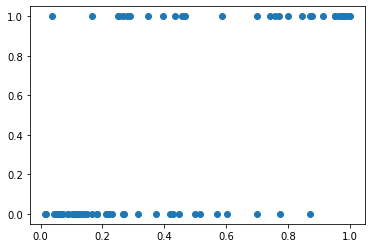

In [31]:
plt.plot(p_hat, C, 'o')

In [32]:
from sklearn.metrics import confusion_matrix, roc_curve

In [33]:
preds_pt5 = p_hat > .5

In [34]:
print('accuracy', onp.mean(preds_pt5 == C))

accuracy 0.76623374


In [35]:
confusion_matrix(preds_pt5, C)

array([[38, 12],
       [ 6, 21]])

In [36]:
preds_pt3 = p_hat > .3

In [37]:
print('accuracy', onp.mean(preds_pt3 == C))

accuracy 0.7532467


In [38]:
confusion_matrix(preds_pt3, C)

array([[32,  7],
       [12, 26]])

Text(0, 0.5, 'true pos rate')

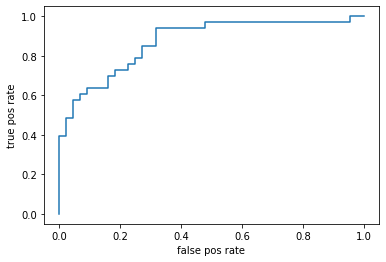

In [39]:
fpr, tpr, thresholds = roc_curve(C, p_hat)
plt.plot(fpr, tpr)
plt.xlabel('false pos rate')
plt.ylabel('true pos rate')

### ETC - make sure I made the laplace distribution correctly

In [40]:
laplace = Laplace(1, 2.5)
with numpyro.plate('plate', 100000):
    d = numpyro.sample('asdf', laplace, rng_key=rng_key)

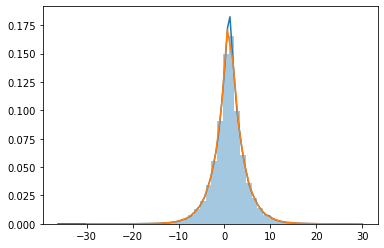

In [41]:
x = onp.linspace(-30, 30)
sns.distplot(d)
plt.plot(x, 1/5 * np.exp(-np.abs(x-1)/2.5))

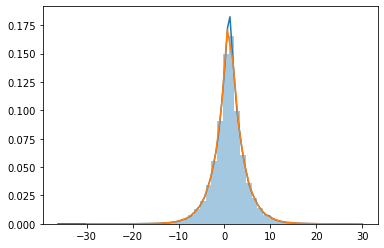

In [42]:
with numpyro.plate('plate', 100000):
    d = 1 + 2.5 * numpyro.sample('asdf', Laplace(0, 1), rng_key=rng_key)
    
x = onp.linspace(-30, 30)
sns.distplot(d)
plt.plot(x, 1/5 * np.exp(-np.abs(x-1)/2.5))

In [43]:
log_probs = laplace.log_prob(x)

In [44]:
from scipy import stats

In [45]:
log_s = stats.laplace.logpdf(x, loc=1, scale=2.5)

In [46]:
d = log_s - log_probs

In [47]:
assert d.mean() <= onp.finfo(np.float32).resolution